<a href="https://colab.research.google.com/github/safaeOulaja/Multi-Model-Traffic-Analysis/blob/main/Traffic_Analysis_YOLOv8_Attention_Unet_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers segmentation-models-pytorch ultralytics roboflow
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from segmentation_models_pytorch import Unet
from roboflow import Roboflow
from ultralytics import YOLO

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=58c2b5b52141f4a95e5ffab935b1fe2a1c173f1efe627165a687c98cc1ea9b4e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none

In [ ]:
# Load dataset
rf = Roboflow(api_key="")
project = rf.workspace("farzad").project("vehicle_detection_yolov8")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehicle_Detection_YOLOv8-3 in yolov8:: 100%|██████████| 1261/1261 [00:00<00:00, 2508.71it/s]


In [ ]:
dataset_path = dataset.location
print(f"Dataset path: {dataset_path}")

#dataset folder structure
for subdir, dirs, files in os.walk(dataset_path):
    print(f"{subdir} contains {len(files)} files.")

Dataset path: /content/Vehicle_Detection_YOLOv8-3
/content/Vehicle_Detection_YOLOv8-3 contains 3 files.
/content/Vehicle_Detection_YOLOv8-3/valid contains 0 files.
/content/Vehicle_Detection_YOLOv8-3/valid/images contains 90 files.
/content/Vehicle_Detection_YOLOv8-3/valid/labels contains 90 files.
/content/Vehicle_Detection_YOLOv8-3/train contains 0 files.
/content/Vehicle_Detection_YOLOv8-3/train/images contains 536 files.
/content/Vehicle_Detection_YOLOv8-3/train/labels contains 536 files.


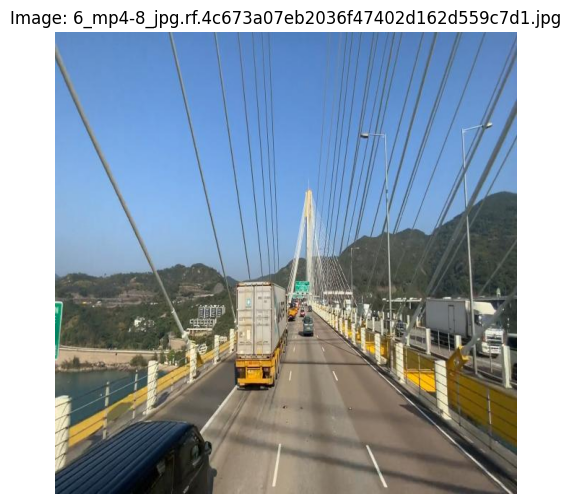

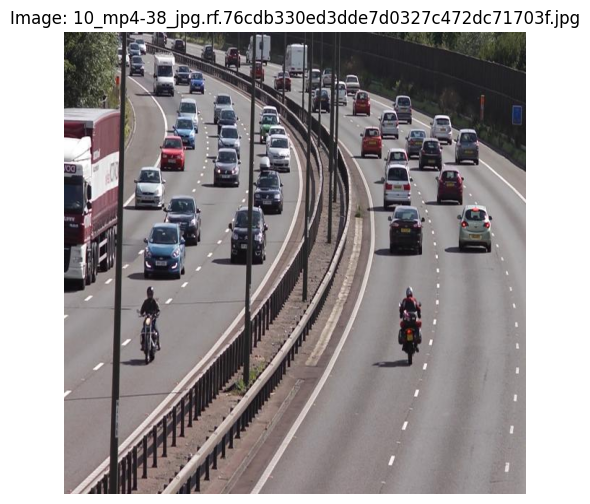

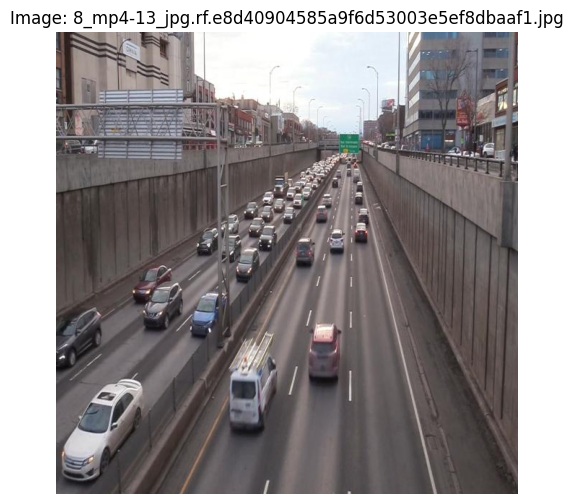

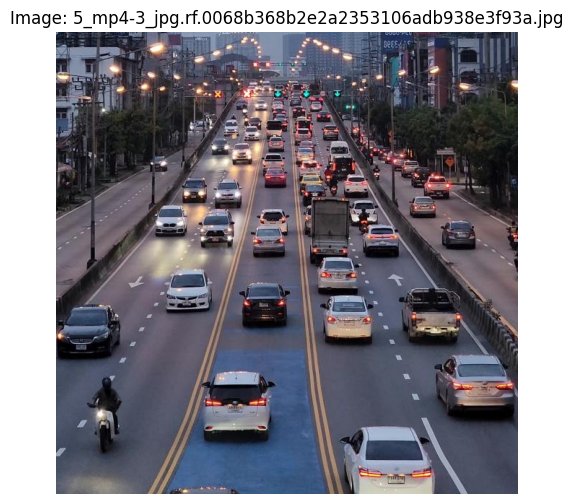

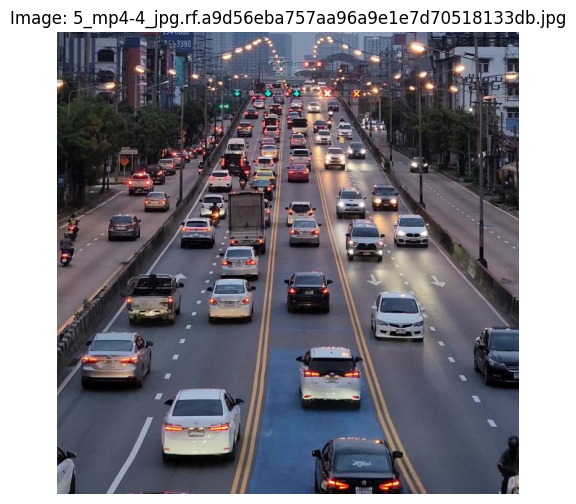

In [ ]:
train_images_path = os.path.join(dataset.location, "train/images")

#listing all image files
image_files = [f for f in os.listdir(train_images_path) if f.endswith(('.jpg', '.png'))]

#visualizing the first 5 images
for i, image_file in enumerate(image_files[:5]):
    img_path = os.path.join(train_images_path, image_file)
    img = cv2.imread(img_path)# loading the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#converting it to RGB

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image: {image_file}")
    plt.axis('off')
    plt.show()


In [ ]:
# Configuration de l'appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# charger le model Vision Transformer pour la classification
def load_vit_model():
    vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    vit.classifier = torch.nn.Linear(vit.classifier.in_features, 2)  # 2 classes : Embouteillage ou Pas d'embouteillage
    vit.to(device).eval()
    return vit

In [ ]:
# Charger le model Attention U-Net pour la segme,tation
def load_attention_unet():
    unet = Unet(
        encoder_name="vgg16",  # Utiliser l'encodeur vgg16
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        decoder_attention_type="scse"  # ajouter le mechanism d'attention
    )
    return unet.to(device).eval()

In [ ]:
# Charger un modèle YOLOv8 pré-entraîné pour détecter des objets
def detect_vehicles_yolo(image, model):
    # Redimensionner et normalise une image
    img = cv2.resize(image, (640, 640))
    img = img / 255.0
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    # Effectue une détection avec YOLOv8
    img_tensor = torch.tensor(img, dtype=torch.float32).to(device)
    results = model(img_tensor)
    detections = []

    for result in results[0].boxes.data:
        x1, y1, x2, y2, confidence, cls = result.cpu().numpy()
        # Filtrer les objets détectés pour ne garder que les véhicules avec une confiance supérieure à 0.5
        if int(cls) == 0 and confidence > 0.5:
            detections.append([int(x1), int(y1), int(x2), int(y2), confidence])
    return detections

In [ ]:
# Prépare l’image pour ViT en utilisant un extracteur de caractéristiques pré-entraîné
def preprocess_image_for_vit(image):
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    return inputs

# YOLOv8 --> Compte les véhicules détectés.
# Attention U-Net --> Génère un masque de segmentation pour identifier les zones d’intérêt.
# ViT --> Prédit si une image représente un embouteillage en fonction des caractéristiques globales.
def process_image(image_path, vit_model, unet_model, yolo_model, traffic_jam_threshold=10):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur : Impossible de charger l'image {image_path}")
        return False, 0
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    detections = detect_vehicles_yolo(image_rgb, yolo_model)
    vehicle_count = len(detections)

    img_resized = cv2.resize(image, (256, 256))
    img_resized = img_resized / 255.0
    img_resized = np.transpose(img_resized, (2, 0, 1))
    img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        mask = unet_model(img_tensor).squeeze(0).squeeze(0).cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8)

    preprocessed_image = preprocess_image_for_vit(image_rgb)
    with torch.no_grad():
        outputs = vit_model(**preprocessed_image)
        probs = torch.softmax(outputs.logits, dim=1)
        is_jam_predicted = probs[0, 1].item() > 0.5

    is_jam = vehicle_count > traffic_jam_threshold
    box_color = (0, 255, 0) if not is_jam else (255, 0, 0)
    for x1, y1, x2, y2, confidence in detections:
        cv2.rectangle(image, (x1, y1), (x2, y2), box_color, 2)
        cv2.putText(image, f"Vehicle {confidence:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)

    title_color = 'green' if not is_jam else 'red'
    title = f"Detected Vehicles: {vehicle_count}"
    if is_jam:
        title += " | Traffic Jam Detected!"

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title, fontsize=16, color=title_color)
    plt.axis("off")
    plt.show()

    return is_jam, vehicle_count

In [ ]:
# Tester sur le dataset
def test_on_dataset(dataset_path, vit_model, unet_model, yolo_model, output_file):
    total_images = 0
    traffic_jam_count = 0

    with open(output_file, "w", encoding="utf-8") as f:
        f.write("Résultats de la détection d'embouteillages\n")
        f.write("=" * 50 + "\n")

        for image_name in os.listdir(dataset_path):
            image_path = os.path.join(dataset_path, image_name)
            is_jam, vehicle_count = process_image(image_path, vit_model, unet_model, yolo_model)

            if is_jam:
                traffic_jam_count += 1
                f.write(f"[Embouteillage détecté] {image_name} | Véhicules : {vehicle_count}\n")
            else:
                f.write(f"[Pas d'embouteillage] {image_name} | Véhicules : {vehicle_count}\n")

            total_images += 1

        f.write("\nRésumé\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total des images analysées : {total_images}\n")
        f.write(f"Total des embouteillages détectés : {traffic_jam_count}\n")

    print("Analyse terminée !")
    print(f"Total des images analysées : {total_images}")
    print(f"Total des embouteillages détectés : {traffic_jam_count}")
    print(f"Les résultats détaillés ont été enregistrés dans {output_file}")

In [ ]:
# charger le model YOLO
yaml_config_path = "/content/Vehicle_Detection_YOLOv8-3/data.yaml"
yolo_model = YOLO("/content/drive/MyDrive/yolov8s.pt").to(device)
yolo_model.train(data=yaml_config_path, epochs=5, imgsz=640, batch=32, name="vehicle_detection", pretrained=True)

# Charger les models
vit_model = load_vit_model()
unet_model = load_attention_unet()
yolo_model = YOLO("/content/runs/detect/vehicle_detection/weights/best.pt").to(device)
output_file = "/content/drive/MyDrive/results.txt"

# Tester sur la DataSet
# Tester l’ensemble de validation en combinant YOLOv8, Attention U-Net et ViT
test_on_dataset('/content/Vehicle_Detection_YOLOv8-3/valid/images', vit_model, unet_model, yolo_model, output_file)